In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
import pathlib
import PIL
import time
import zipfile
import random
from tensorflow import keras as ks
from tensorflow.keras.layers import *
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [93]:
train_df=pd.read_csv("../input/road-segment-identification/Train (4).csv")
test_df=pd.read_csv("../input/road-segment-identification/Test (6).csv")
sub=pd.read_csv("../input/road-segment-identification/SampleSubmission (2).csv")


In [94]:
train_df.head()

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1


In [95]:
Id=test_df["Image_ID"]

In [96]:
path='../input/road-segment-identification/Images/Images/'
img_paths = []
for i in train_df.Image_ID[:7000]:
    img_paths.append(path + i+".tif")
train_df['path'] = img_paths

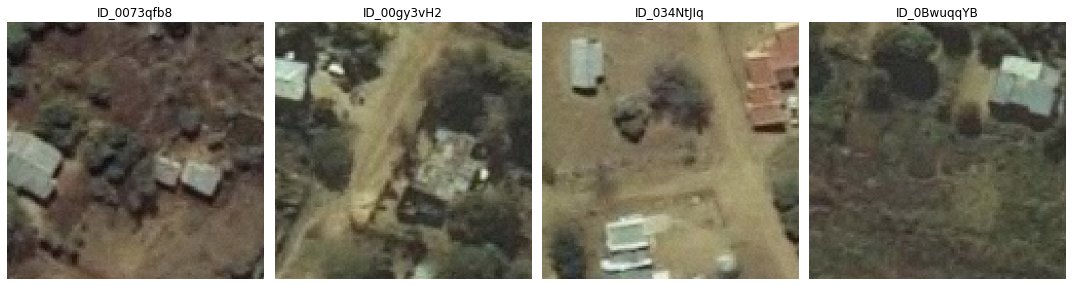

In [97]:
import matplotlib.image as mpimg
path = '../input/road-segment-identification/Images/Images/'
fig,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 10))
ax = [ax1, ax2, ax3, ax4]
for i in range(4):
    img = mpimg.imread(path+train_df['Image_ID'][i**3]+'.tif')
    ax[i].imshow(img)
    ax[i].set_title(train_df['Image_ID'][i**3])
    ax[i].axis('off')
plt.tight_layout()
plt.show()
    

Text(0, 0.5, 'Number of images')

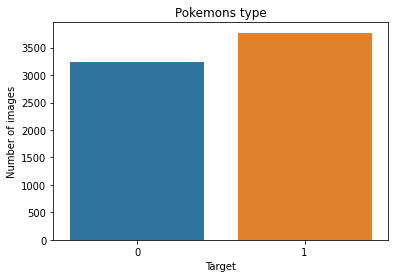

In [98]:
import seaborn as sns
sns.countplot(x=train_df.Target,)
plt.title('Pokemons type')
plt.ylabel('Number of images')

In [99]:
train_df.head()

,Image_ID,Target,path
0,ID_0073qfb8,0,../input/road-segment-identification/Images/Im...
1,ID_00gy3vH2,1,../input/road-segment-identification/Images/Im...
2,ID_00uB3UFr,0,../input/road-segment-identification/Images/Im...
3,ID_012xZpNw,1,../input/road-segment-identification/Images/Im...
4,ID_014GgMRb,1,../input/road-segment-identification/Images/Im...


In [100]:
train_datagenerator = ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest',
    validation_split=0.1)

In [125]:
train_generator = train_datagenerator.flow_from_dataframe(
    train_df, 
    x_col='path', 
    y_col='Target',
    target_size=(120, 120), 
    color_mode='rgba', 
    class_mode='raw', 
    batch_size=32, 
    shuffle=True, 
    seed=1,
    subset='training')
validation_generator = train_datagenerator.flow_from_dataframe(
    train_df , 
    x_col='path',
    y_col='Target',
    target_size=(120, 120),
    color_mode='rgba', 
    class_mode='raw', 
    batch_size=4, 
    shuffle=True,
    seed=1, 
    subset='validation'
)

Found 6300 validated image filenames.
Found 700 validated image filenames.


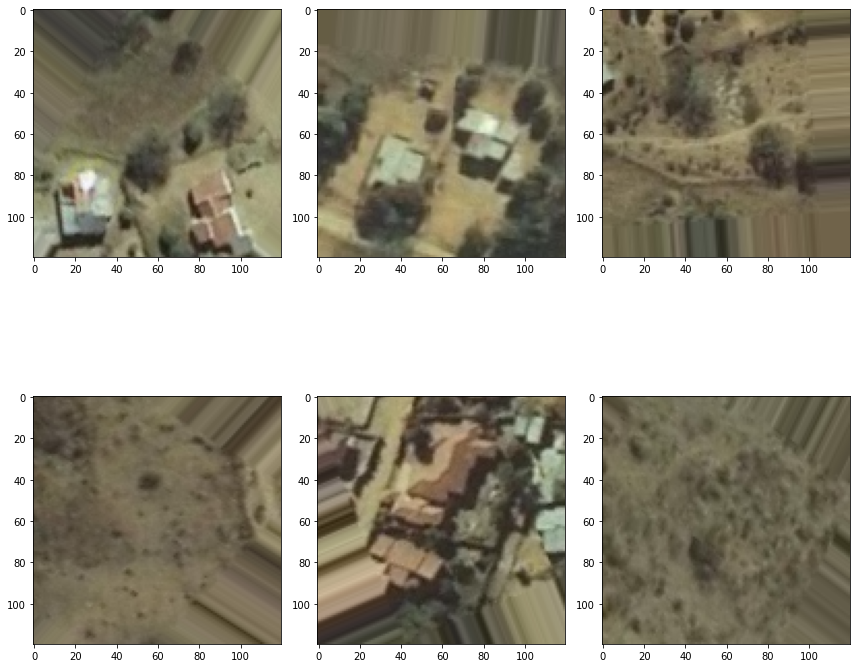

In [102]:
plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [126]:
model = ks.models.Sequential()

model.add(ks.layers.Dense(4, input_shape=(120, 120, 4)))

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))


model.add(ks.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

model.add(ks.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))
model.add(ks.layers.Dropout(0.2))

        
model.add(ks.layers.Flatten())
        
model.add(ks.layers.Dense(1024, activation='relu'))

model.add(ks.layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [127]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 120, 120, 4)       20        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 118, 118, 64)      2368      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 57, 57, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 26, 26, 256)       295168    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 256)      

In [128]:
batch_size=15
FAST_RUN = False
epochs=5 if FAST_RUN else 100
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/100


2022-07-25 11:46:02.793331: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


197/197 [==============================] - 67s 301ms/step - loss: 0.6732 - acc: 0.5902 - val_loss: 0.5784 - val_acc: 0.7400
Epoch 2/100
197/197 [==============================] - 42s 212ms/step - loss: 0.5751 - acc: 0.7071 - val_loss: 0.5614 - val_acc: 0.7271
Epoch 3/100
197/197 [==============================] - 42s 211ms/step - loss: 0.5606 - acc: 0.7135 - val_loss: 0.5124 - val_acc: 0.7443
Epoch 4/100
197/197 [==============================] - 42s 212ms/step - loss: 0.5567 - acc: 0.7135 - val_loss: 0.5239 - val_acc: 0.7343
Epoch 5/100
197/197 [==============================] - 42s 211ms/step - loss: 0.5594 - acc: 0.7160 - val_loss: 0.5280 - val_acc: 0.7486
Epoch 6/100
197/197 [==============================] - 42s 211ms/step - loss: 0.5439 - acc: 0.7283 - val_loss: 0.5241 - val_acc: 0.7429
Epoch 7/100
197/197 [==============================] - 41s 209ms/step - loss: 0.5333 - acc: 0.7321 - val_loss: 0.5207 - val_acc: 0.7257
Epoch 8/100
197/197 [==============================] - 42s 2

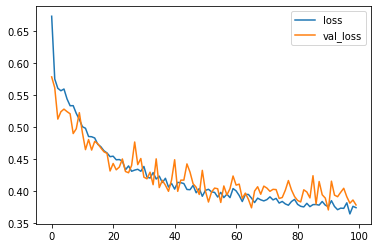

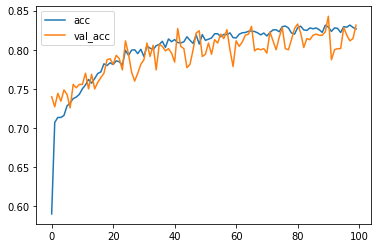

In [129]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['acc', 'val_acc']].plot();

In [130]:
path='../input/road-segment-identification/Images/Images/'
img_paths = []
for i in test_df.Image_ID:
    img_paths.append(path + i+".tif")
test_df['path'] = img_paths

In [138]:
predictions = model.predict(test_df['path'])

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:254 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_4 is incompatible with the layer: expected axis -1 of input shape to have value 4 but received input with shape (None, 1)


In [ ]:
preds = np.argmax(predictions, axis = 1)
test_df["Target"]=preds